In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# An Analysis of Political Contributions During the 2020 House of Representatives Election, Part 2

For the first part of this project, you scraped information for all House of Representatives races during 2020 and performed some exploratory analysis.

Now, take the data you gathered and fit a logistic regression model to see if the amount spent has a statistically significant impact on the probability of winning an election.

Feel free to brainstorm ways to set up your model, but a suggestion to get started would be to calculate, for each candidate, the percentage of to total amount spent in their race that was spent by them and use this as your predictor variable of interest. Hint: you may find the `transform` method (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html) in combination with `groupby` useful to find the total spending by race.

Don't forget to include the incumbent variable in your model.

After fitting your model, interpret the meaning of the coefficients you get.

In [2]:
candidates = pd.read_csv('../Data/candidates.csv')

In [3]:
candidates = candidates.rename(columns = {'Incumbent Status': 'Incumbent', 'District Number': 'District_Number', 'Winner Status': 'Winner', 'Percentage of Vote': 'Percentage_of_Vote', 'Total Amount Spent': 'Total_Amount_Spent', 'Total Amount Raised': 'Total_Amount_Raised'})
candidates.head()

,Name,Party,State,District_Number,Incumbent,Winner,Percentage_of_Vote,Total_Amount_Raised,Total_Amount_Spent
0,Jerry Carl,(R),Alabama,District 01,N/a,Winner,64.9,1971321,1859349
1,James Averhart,(D),Alabama,District 01,N/a,N/a,35.0,80095,78973
2,Barry Moore,(R),Alabama,District 02,N/a,Winner,65.3,650807,669368
3,Phyllis Harvey-Hall,(D),Alabama,District 02,N/a,N/a,34.6,56050,55988
4,Mike D Rogers,(R),Alabama,District 03,Incumbent,Winner,67.5,1193111,1218564


In [4]:
#First add binary markers for each of the categorical variables 
candidates['Incumbent'] = (candidates['Incumbent'] == 'Incumbent').astype(int)
candidates['Winner'] = (candidates['Winner'] == 'Winner').astype(int)

candidates.head()

,Name,Party,State,District_Number,Incumbent,Winner,Percentage_of_Vote,Total_Amount_Raised,Total_Amount_Spent
0,Jerry Carl,(R),Alabama,District 01,0,1,64.9,1971321,1859349
1,James Averhart,(D),Alabama,District 01,0,0,35.0,80095,78973
2,Barry Moore,(R),Alabama,District 02,0,1,65.3,650807,669368
3,Phyllis Harvey-Hall,(D),Alabama,District 02,0,0,34.6,56050,55988
4,Mike D Rogers,(R),Alabama,District 03,1,1,67.5,1193111,1218564


In [5]:
amount_spent_logreg = smf.logit("Winner ~ Total_Amount_Spent",
                          data = candidates).fit()
amount_spent_logreg.summary()

Optimization terminated successfully.
         Current function value: 0.650902
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Winner   No. Observations:                  895
Model:                          Logit   Df Residuals:                      893
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                 0.06013
Time:                        10:21:50   Log-Likelihood:                -582.56
converged:                       True   LL-Null:                       -619.83
Covariance Type:            nonrobust   LLR p-value:                 5.927e-18
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5507      0.091     -6.035      0.000      -0.730      -0.372
Total_Amount_Spent  3.184e-07   4.38e-08      7.265      0.000    2.32e-07    4.04e-07
======================================================================================
"""

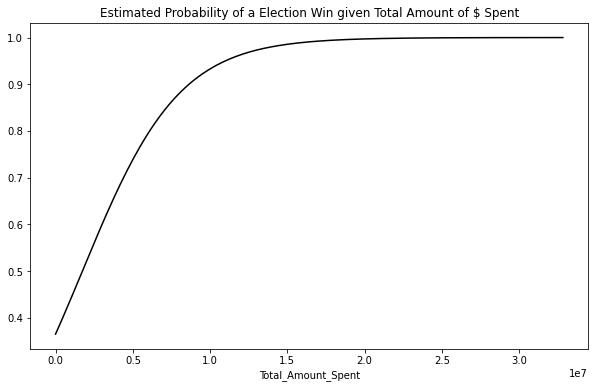

In [6]:
fit_df = pd.DataFrame({
    'Total_Amount_Spent': np.linspace(start = candidates['Total_Amount_Spent'].min(),
                            stop = candidates['Total_Amount_Spent'].max(),
                            num = 150)
})

fit_df['fit'] = amount_spent_logreg.predict(fit_df)

fit_df.plot(x = 'Total_Amount_Spent',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of a Election Win given Total Amount of $ Spent');

In [11]:
amt_spent_summary = (
    candidates
    .assign(group = pd.qcut(candidates['Total_Amount_Spent'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group')
    ['Winner', 'Total_Amount_Spent']
    .mean()
    .reset_index()
    .rename(columns = {'Winner': 'eprob'})
)
amt_spent_summary.head()

C:\Users\jacks\AppData\Local\Temp\ipykernel_49508\1390072994.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  candidates


,group,eprob,Total_Amount_Spent
0,"(-4965.001, 14810.6]",0.000000,5183.077778
1,"(14810.6, 61984.4]",0.000000,34588.235955
2,"(61984.4, 204182.2]",0.022222,115941.855556
3,"(204182.2, 587537.4]",0.382022,374470.426966
4,"(587537.4, 944010.0]",0.800000,766932.255556


In [12]:
amt_spent_summary['fit_prob'] = amount_spent_logreg.predict(amt_spent_summary[['Total_Amount_Spent']])
amt_spent_summary

,group,eprob,Total_Amount_Spent,fit_prob
0,"(-4965.001, 14810.6]",0.000000,5.183078e+03,0.366077
1,"(14810.6, 61984.4]",0.000000,3.458824e+04,0.368252
2,"(61984.4, 204182.2]",0.022222,1.159419e+05,0.374298
3,"(204182.2, 587537.4]",0.382022,3.744704e+05,0.393764
4,"(587537.4, 944010.0]",0.800000,7.669323e+05,0.423951
5,"(944010.0, 1304501.4]",0.842697,1.115997e+06,0.451294
6,"(1304501.4, 1753200.4]",0.775281,1.548197e+06,0.485542
7,"(1753200.4, 2545294.4]",0.788889,2.061969e+06,0.526404
8,"(2545294.4, 4327186.0]",0.651685,3.327707e+06,0.624496
9,"(4327186.0, 32830607.0]",0.566667,7.453306e+06,0.860819


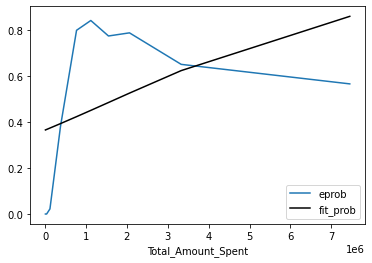

In [13]:
ax = amt_spent_summary.plot(x = 'Total_Amount_Spent', y = 'eprob')
amt_spent_summary.plot(x = 'Total_Amount_Spent', y = 'fit_prob',
                color = 'black',
                ax = ax);

In [14]:
amt_spent_summary['elogit'] = np.log(amt_spent_summary['eprob'] / (1 - amt_spent_summary['eprob']))
amt_spent_summary['fit_logit'] = np.log(amt_spent_summary['fit_prob'] / (1 - amt_spent_summary['fit_prob']))
amt_spent_summary

c:\Users\jacks\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,group,eprob,Total_Amount_Spent,fit_prob,elogit,fit_logit
0,"(-4965.001, 14810.6]",0.000000,5.183078e+03,0.366077,-inf,-0.549085
1,"(14810.6, 61984.4]",0.000000,3.458824e+04,0.368252,-inf,-0.539724
2,"(61984.4, 204182.2]",0.022222,1.159419e+05,0.374298,-3.784190,-0.513824
3,"(204182.2, 587537.4]",0.382022,3.744704e+05,0.393764,-0.480973,-0.431519
4,"(587537.4, 944010.0]",0.800000,7.669323e+05,0.423951,1.386294,-0.306574
5,"(944010.0, 1304501.4]",0.842697,1.115997e+06,0.451294,1.678431,-0.195445
6,"(1304501.4, 1753200.4]",0.775281,1.548197e+06,0.485542,1.238374,-0.057850
7,"(1753200.4, 2545294.4]",0.788889,2.061969e+06,0.526404,1.318241,0.105715
8,"(2545294.4, 4327186.0]",0.651685,3.327707e+06,0.624496,0.626456,0.508677
9,"(4327186.0, 32830607.0]",0.566667,7.453306e+06,0.860819,0.268264,1.822107


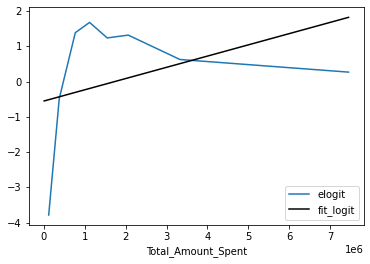

In [15]:
ax = amt_spent_summary.plot(x = 'Total_Amount_Spent', y = 'elogit')
amt_spent_summary.plot(x = 'Total_Amount_Spent', y = 'fit_logit',
                color = 'black',
                ax = ax);